In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
import importlib
import models
importlib.reload(models)
from models import get_conn, TickedRoute
pd.set_option('display.expand_frame_repr', False) # display full data in terminal
%matplotlib inline

engine, Session = get_conn()


In [134]:
# build total style_counts dict
with Session() as session:
    ticked_routes_statement = session.query(TickedRoute).statement
    df = pd.read_sql(ticked_routes_statement, con=session.bind)

# distinct_ratings = df['rating'].unique()
# easy grades = []'5.5','5.6','5.7','5.7+','5.8-','5.8','5.8+','5.9-','5.9','5.9+]
# grade_order = ['5.10-','5.10a','5.10a/b','5.10b','5.10','5.10b/c','5.10c','5.10c/d','5.10d','5.10+','5.11-','5.11a','5.11a/b','5.11b','5.11','5.11b/c','5.11c','5.11c/d','5.11d','5.11+','5.12-','5.12a','5.12a/b','5.12b','5.12','5.12b/c','5.12c','5.12c/d','5.12d','5.13a','5.13b']
grade_map = {
    '5.9': ['5.9-','5.9','5.9+'],
    '5.10-': ['5.10-','5.10a','5.10a/b'],
    '5.10':  ['5.10b','5.10','5.10b/c', '5.10c'],
    '5.10+': ['5.10c/d','5.10d','5.10+'],
    '5.11-': ['5.11-','5.11a','5.11a/b'],
    '5.11':  ['5.11b','5.11','5.11b/c','5.11c'],
    '5.11+': ['5.11c/d','5.11d','5.11+'],
    '5.12-': ['5.12-','5.12a','5.12a/b'],
    '5.12':  ['5.12b','5.12','5.12b/c','5.12c'],
    '5.12+': ['5.12c/d','5.12d','5.12+'],   
    '5.13-': ['5.13-','5.13a','5.13a/b'],
    '5.13':  ['5.13b','5.13','5.13b/c','5.13c'],
}

def build_style_counts_dict(df):
    os_flash, redpoint, fell_hung = [], [], []

    # populate the above arrays with counts for each grade
    for _grade, grade_list in grade_map.items():
        routes = df[df['rating'].isin(grade_list)]
        os_count = routes[routes['lead_style'] == 'Onsight/Flash'].shape[0]
        rp_count = routes[routes['lead_style'] == 'Redpoint'].shape[0]
        fh_count = routes[routes['lead_style'] == 'Fell/Hung'].shape[0]
        os_flash.append(os_count)
        redpoint.append(rp_count)
        fell_hung.append(fh_count)

    return {
        'Onsight/Flash': np.array(os_flash),
        'Redpoint': np.array(redpoint),
        'Fell/Hung': np.array(fell_hung) 
    }

total_style_counts = build_style_counts_dict(df)


In [127]:
# build style counts dict partitioned by year
# {
#     2014: {
#         'Redpoint': np.array(redpoint),
#         'Fell/Hung': np.array(fell_hung),
#         'Onsight/Flash': np.array(os_flash)
#     },
#     2015: {
#         'Redpoint': np.array(redpoint),
#         'Fell/Hung': np.array(fell_hung),
#         'Onsight/Flash': np.array(os_flash)
#     }
# }

# add year column for graph
df['year'] = pd.to_datetime(df['date']).dt.year
years = df['year'].unique()
years.sort()

yearly_style_counts = {}
for year in years:
    year_df = df[df['year'] == year]
    yearly_style_counts[year] = build_style_counts_dict(year_df)

In [ ]:
# plot climbing style by grade, total counts. TODO: ADD YEAR BREAKDOWN TO THIS TOO
fig, ax = plt.subplots(figsize=(20, 7))

def annotate_bars(bars, style_count, total_counts):
    for bar, count, total in zip(bars, style_count, total_counts):
        percentage = (count / total) * 100 if total > 0 else 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{percentage:.1f}%',
            ha='center',
            va='center',
            fontsize=10
        )

# Plot each style as a stacked bar
def plot_stacked_bars(style_counts):
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bottom = np.zeros(len(grade_map.keys()))
    width = 0.7
    total_counts = np.sum(list(style_counts.values()), axis=0)
    for i, (style, style_count) in enumerate(style_counts.items()):
        bars = ax.bar(grade_map.keys(), style_count, label=style, width=width, bottom=bottom, color=colors[i])
        annotate_bars(bars, style_count, total_counts)
        bottom += style_count

    ax.set_title("Climbing Style Stats", fontsize=18, fontweight='bold')
    ax.set_xticks(range(len(grade_map.keys())))
    ax.set_xticklabels(grade_map.keys(), fontsize=14)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_xlabel('Grade', fontsize=18)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='y')

    # Reorder handles and labels
    desired_order = ['Fell/Hung', 'Redpoint', 'Onsight/Flash']
    handles, labels = ax.get_legend_handles_labels()
    ordered_handles = [handles[labels.index(style)] for style in desired_order]
    ordered_labels = [style for style in desired_order]
    ax.legend(ordered_handles, ordered_labels, loc='best', fontsize=20)

    plt.tight_layout(pad=2)
    plt.show()

plot_stacked_bars(total_style_counts)

/tmp/ipykernel_61/2975805838.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


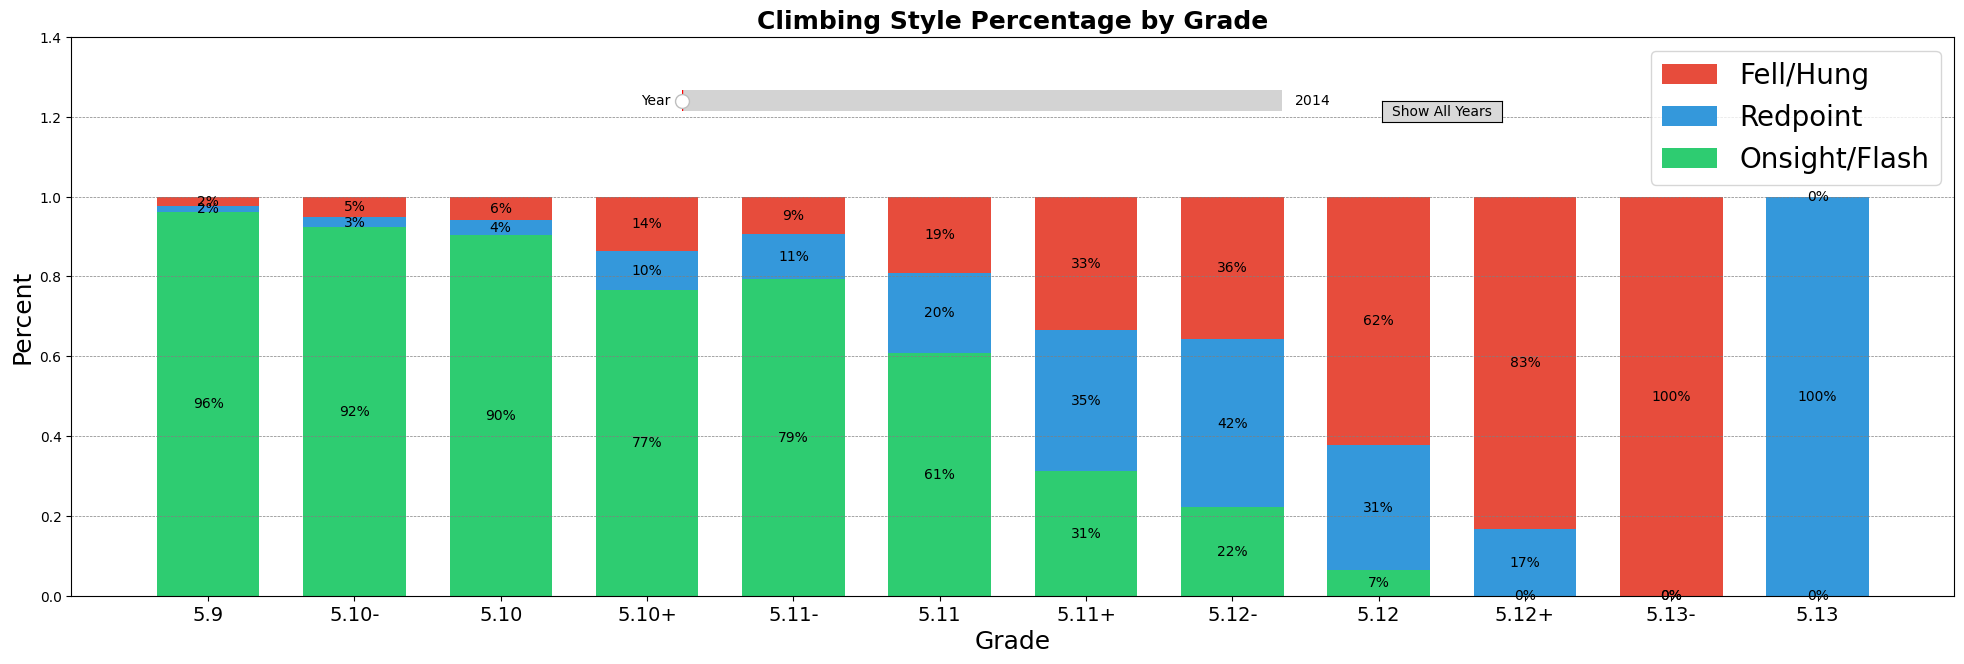

In [175]:
# plot climbing style by grade, percentage. # TODO: change opacity or something to indicate total number of routes for each grade bar.

fig_pct, ax_pct = plt.subplots(figsize=(20, 7))

def annotate_bars(bars, pct_list):
    for bar, pct in zip(bars, pct_list):
        ax_pct.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{100*pct:.0f}%',
            ha='center',
            va='center',
            fontsize=10
        )

def init_chart():
    add_year_slider()

def plot_normalized_stacked_bars(style_counts):
    total_counts = np.sum(list(style_counts.values()), axis=0)
    style_percentages = {}
    for i, (style, style_count) in enumerate(style_counts.items()):
        with np.errstate(divide='ignore', invalid='ignore'):
            percentages = np.true_divide(style_count, total_counts)
            percentages[~np.isfinite(percentages)] = 0  # set -inf, inf, NaN to 0
        style_percentages[style] = percentages

    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bottom = np.zeros(len(grade_map.keys()))
    width = 0.7
    for i, (style, pct_list) in enumerate(style_percentages.items()):
        bars = ax_pct.bar(grade_map.keys(), pct_list, label=style, width=width, bottom=bottom, color=colors[i])
        annotate_bars(bars, pct_list)
        bottom += pct_list

    ax_pct.set_title("Climbing Style Percentage by Grade", fontsize=18, fontweight='bold')
    ax_pct.set_xticks(range(len(grade_map.keys())))
    ax_pct.set_xticklabels(grade_map.keys(), fontsize=14)
    ax_pct.set_ylabel('Percent', fontsize=18)
    ax_pct.set_xlabel('Grade', fontsize=18)
    ax_pct.set_ylim(0, 1.4)
    ax_pct.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='y')

    # Reorder handles and labels
    desired_order = ['Fell/Hung', 'Redpoint', 'Onsight/Flash']
    handles, labels = ax_pct.get_legend_handles_labels()
    ordered_handles = [handles[labels.index(style)] for style in desired_order]
    ordered_labels = [style for style in desired_order]
    ax_pct.legend(ordered_handles, ordered_labels, loc='upper right', fontsize=20)

    plt.tight_layout(pad=2)
    plt.show()


def update_chart(selected_year):
    ax.clear()
    if selected_year == 'All':
        plot_normalized_stacked_bars(total_style_counts)
    else:
        plot_normalized_stacked_bars(yearly_style_counts[selected_year])
    
    ax.set_title(f'Climbing Ticks - {selected_year}')
    fig.canvas.draw_idle()

def add_year_slider():
    years = df['year'].unique()
    years.sort()
    min_year = min(years)
    max_year = max(years)

    button_ax = plt.axes([0.7, 0.8, 0.06, 0.03])
    show_all_button = plt.Button(button_ax, 'Show All Years')

    slider_ax = plt.axes([0.35, 0.8, 0.3, 0.06])
    year_slider = Slider(
        ax=slider_ax,
        label='Year',
        valmin=min_year,
        valmax=max_year,
        valinit=min_year,
        valstep=1,  # Step by whole years
    )

    def slider_update(val):
        update_chart(int(val))
    
    def show_alll_years(event):
        update_chart('All')
    
    # Connect the callbacks
    year_slider.on_changed(slider_update)
    show_all_button.on_clicked(show_alll_years)
    
    # Initial plot
    update_chart('All')

# plot_normalized_stacked_bars(total_style_counts)
init_chart()

In [ ]:
# TODO: make the above, but allow interactive selection of the year, so i can scroll through the years and watch the graph change.
